In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels
tf.enable_v2_behavior()

from mpl_toolkits.mplot3d import Axes3D
%pylab inline
# Configure plot defaults
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['grid.color'] = '#666666'
%config InlineBackend.figure_format = 'png'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [4]:
def transform(X_data):
    return 2*X_data[:,0] + 4*X_data[:,1] + 6*X_data[:,2] + 8*X_data[:,3]

In [5]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
path = 'dataset/'
X_train = np.load(path+'X_train_1d.npy')
X_test = np.load(path+'X_test_1d.npy')
X_val = np.load(path+'X_val_1d.npy') #this may not be required for now

t_train = np.load(path+'y_grain_cond_ka_train.npy')
# t_train = np.where(t_train>=0, 1, 0)
t_test = np.load(path+'y_grain_cond_ka_test.npy')
# t_test = np.where(t_test>=0, 1, 0)
t_val = np.load(path+'y_grain_cond_ka_val.npy') #this may not be required for now
# t_val = np.where(t_val>=0, 1, 0)

del_idx_train = np.unique(np.where(np.isnan(X_train))[0])
del_idx_test = np.unique(np.where(np.isnan(X_test))[0])
del_idx_val = np.unique(np.where(np.isnan(X_val))[0])

X_train = np.delete(X_train, del_idx_train, axis=0)
t_train = np.delete(t_train, del_idx_train, axis=0)

X_test = np.delete(X_test, del_idx_test, axis=0)
t_test = np.delete(t_test, del_idx_test, axis=0)

X_val = np.delete(X_val, del_idx_val, axis=0)
t_val = np.delete(t_val, del_idx_val, axis=0)

# Using just the positive kink angles
neg_ixd_train = np.where(t_train<0)[0]
neg_ixd_test = np.where(t_test<0)[0]
neg_ixd_val = np.where(t_val<0)[0]

X_train = np.delete(X_train, neg_ixd_train, axis=0)
t_train = np.delete(t_train, neg_ixd_train, axis=0)

X_test = np.delete(X_test, neg_ixd_test, axis=0)
t_test = np.delete(t_test, neg_ixd_test, axis=0)

X_val = np.delete(X_val, neg_ixd_val, axis=0)
t_val = np.delete(t_val, neg_ixd_val, axis=0)

#transform data
X_train = transform(X_train)
X_test = transform(X_test)
X_val = transform(X_val)

#deleting duplicates:
X_train, idx_train = np.unique(X_train, return_index=True)
t_train = t_train[idx_train]

X_test, idx_test = np.unique(X_test, return_index=True)
t_test = t_test[idx_test]

X_val, idx_val = np.unique(X_val, return_index=True)
t_val = t_val[idx_val]

#data normalization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1,1))
X_test = scaler.transform(X_test.reshape(-1,1))
X_val = scaler.transform(X_val.reshape(-1,1))
scaler2 = StandardScaler()
t_train = scaler2.fit_transform(t_train.reshape(-1,1))
t_test = scaler2.transform(t_test.reshape(-1,1))
t_val = scaler2.transform(t_val.reshape(-1,1))

In [7]:
def generate_1d_data():
    observation_index_points_ = X_train.reshape(-1,1)
    observations_ = t_train.ravel()
    return observation_index_points_, observations_

In [8]:
observation_index_points_, observations_ = generate_1d_data()

In [9]:
def build_gp(amplitude, length_scale, observation_noise_variance):
  """Defines the conditional dist. of GP outputs, given kernel parameters."""

  # Create the covariance kernel, which will be shared between the prior (which we
  # use for maximum likelihood training) and the posterior (which we use for
  # posterior predictive sampling)
  kernel = tfk.ExponentiatedQuadratic(amplitude, length_scale)

  # Create the GP prior distribution, which we will use to train the model
  # parameters.
  return tfd.GaussianProcess(
      kernel=kernel,
      index_points=observation_index_points_,
      observation_noise_variance=observation_noise_variance)

gp_joint_model = tfd.JointDistributionNamed({
    'amplitude': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'length_scale': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'observation_noise_variance': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'observations': build_gp,
})

In [10]:
x = gp_joint_model.sample()
lp = gp_joint_model.log_prob(x)

print("sampled {}".format(x))
print("log_prob of sample: {}".format(lp))

Instructions for updating:
`jitter` is deprecated; please use `marginal_fn` directly.
sampled {'observation_noise_variance': <tf.Tensor: shape=(), dtype=float64, numpy=9.718434475862535>, 'length_scale': <tf.Tensor: shape=(), dtype=float64, numpy=1.8121892674508857>, 'amplitude': <tf.Tensor: shape=(), dtype=float64, numpy=0.7002669391362133>, 'observations': <tf.Tensor: shape=(81,), dtype=float64, numpy=
array([-0.10732639,  2.28202561, -2.00798029,  1.84152329,  1.87892618,
        2.31369028,  0.23758031, -1.38420881,  1.850056  , -2.29339546,
       -2.37096025,  2.01071781, -1.8890508 ,  1.79832473,  4.54245727,
       -0.93629472,  5.69970517,  1.32967472,  1.46554433,  2.74019357,
       -2.37537819, -3.29475697, -4.33461121,  0.98122451, -4.15270772,
       -0.95197338,  4.73632094, -3.63204739,  4.6146985 ,  2.23091456,
       -1.01215624,  5.32026023,  0.05661429,  3.113457  , -3.36115668,
       -2.23480675,  4.39082435, -0.48059978,  4.28201339, -3.31253359,
       -3.631711

In [11]:
# Create the trainable model parameters, which we'll subsequently optimize.
# Note that we constrain them to be strictly positive.

constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

amplitude_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='amplitude',
    dtype=np.float64)

length_scale_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='length_scale',
    dtype=np.float64)

observation_noise_variance_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='observation_noise_variance_var',
    dtype=np.float64)

trainable_variables = [v.trainable_variables[0] for v in 
                       [amplitude_var,
                       length_scale_var,
                       observation_noise_variance_var]]

In [12]:
def target_log_prob(amplitude, length_scale, observation_noise_variance):
  return gp_joint_model.log_prob({
      'amplitude': amplitude,
      'length_scale': length_scale,
      'observation_noise_variance': observation_noise_variance,
      'observations': observations_
  })

In [27]:
# Now we optimize the model parameters.
num_iters = 10000
optimizer = tf.optimizers.Adam(learning_rate=.01)

# Use `tf.function` to trace the loss for more efficient evaluation.
@tf.function(autograph=False, jit_compile=False)
def train_model():
  with tf.GradientTape() as tape:
    loss = -target_log_prob(amplitude_var, length_scale_var,
                            observation_noise_variance_var)
  grads = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(grads, trainable_variables))
  return loss

# Store the likelihood values during training, so we can plot the progress
lls_ = np.zeros(num_iters, np.float64)
for i in range(num_iters):
  loss = train_model()
  lls_[i] = loss

print('Trained parameters:')
print('amplitude: {}'.format(amplitude_var._value().numpy()))
print('length_scale: {}'.format(length_scale_var._value().numpy()))
print('observation_noise_variance: {}'.format(observation_noise_variance_var._value().numpy()))

Trained parameters:
amplitude: 0.4644375203595351
length_scale: 0.08839633977798525
observation_noise_variance: 0.8073222399946776


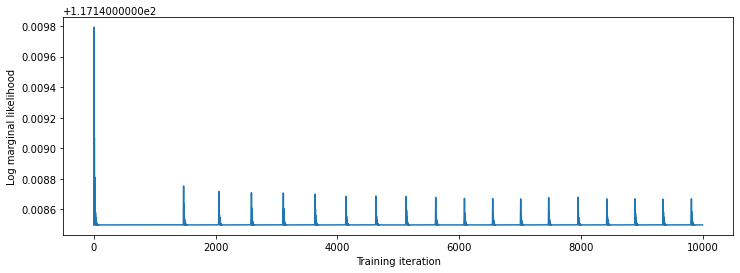

In [28]:
# Plot the loss evolution
plt.figure(figsize=(12, 4))
plt.plot(lls_)
plt.xlabel("Training iteration")
plt.ylabel("Log marginal likelihood")
plt.show()

In [29]:
# Having trained the model, we'd like to sample from the posterior conditioned
# on observations. We'd like the samples to be at points other than the training
# inputs.
predictive_index_points_ = X_test.ravel()
predictive_index_points_ = predictive_index_points_[..., np.newaxis]

optimized_kernel = tfk.ExponentiatedQuadratic(amplitude_var, length_scale_var)
gprm = tfd.GaussianProcessRegressionModel(
    kernel=optimized_kernel,
    index_points=predictive_index_points_,
    observation_index_points=observation_index_points_,
    observations=observations_,
    observation_noise_variance=observation_noise_variance_var,
    predictive_noise_variance=0.)

num_samples = 50
samples = gprm.sample(num_samples)

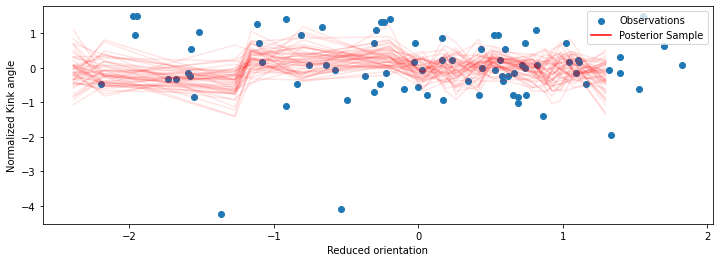

In [33]:
# Plot the true function, observations, and posterior samples.
plt.figure(figsize=(12, 4))
plt.scatter(observation_index_points_[:, 0], observations_,
            label='Observations')
for i in range(num_samples):
  plt.plot(predictive_index_points_, samples[i, :], c='r', alpha=.1,
           label='Posterior Sample' if i == 0 else None)
leg = plt.legend(loc='upper right')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel("Reduced orientation")
plt.ylabel("Normalized Kink angle")
plt.show()